In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix
)
from ipywidgets import interact, FloatSlider


model = joblib.load("../models/fraud_model.pkl")
scaler = joblib.load("../models/scaler.pkl")
threshold = joblib.load("../models/threshold.pkl")

df = pd.read_csv("../data/creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"]

X_scaled = scaler.transform(X)
probs = model.predict_proba(X_scaled)[:,1]

In [5]:
print("ROC-AUC:", roc_auc_score(y, probs))

ROC-AUC: 0.9961279206376644


In [6]:
preds = (probs >= threshold).astype(int)
print(confusion_matrix(y, preds))
print(classification_report(y, preds))


[[239403  44912]
 [     4    488]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    284315
           1       0.01      0.99      0.02       492

    accuracy                           0.84    284807
   macro avg       0.51      0.92      0.47    284807
weighted avg       1.00      0.84      0.91    284807



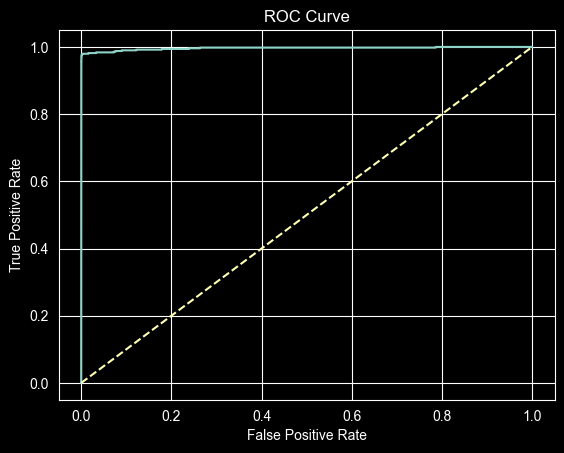

In [7]:
fpr, tpr, _ = roc_curve(y, probs)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


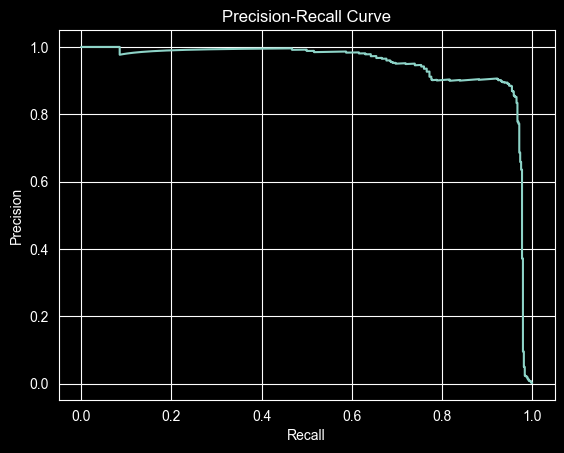

In [8]:
precision, recall, thresholds = precision_recall_curve(y, probs)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [9]:
import pandas as pd

records = []
for t in np.linspace(0,1,200):
    p = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, p).ravel()
    prec = tp / (tp+fp+1e-9)
    rec = tp / (tp+fn+1e-9)
    records.append([t, prec, rec, fn, fp])

df_metrics = pd.DataFrame(records, columns=["threshold","precision","recall","fn","fp"])
df_metrics.head()


,threshold,precision,recall,fn,fp
0,0.000000,0.001727,1.000000,0,284315
1,0.005025,0.002323,0.997967,1,210913
2,0.010050,0.004276,0.997967,1,114337
3,0.015075,0.007105,0.995935,2,68478
4,0.020101,0.010828,0.991870,4,44581


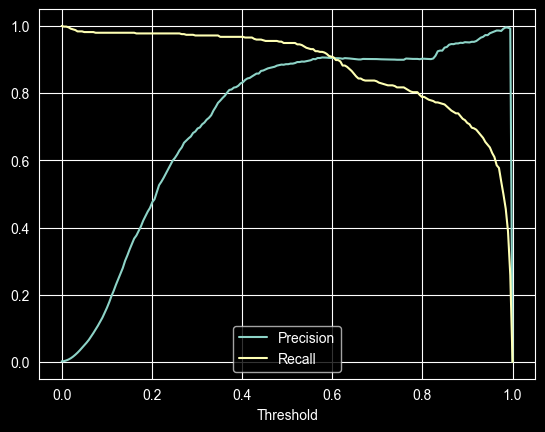

In [10]:
plt.plot(df_metrics["threshold"], df_metrics["precision"], label="Precision")
plt.plot(df_metrics["threshold"], df_metrics["recall"], label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()


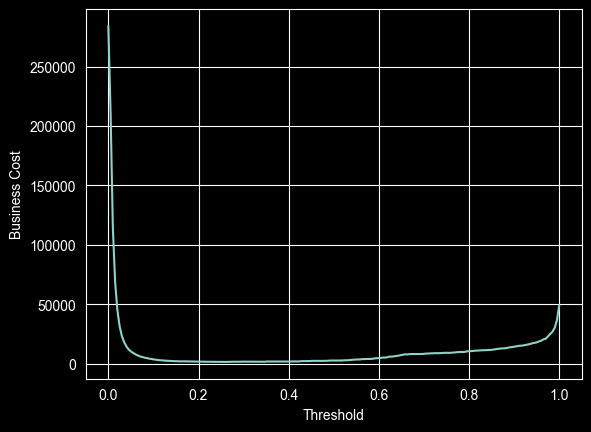

In [11]:
C_FN = 100
C_FP = 1

df_metrics["cost"] = df_metrics["fn"]*C_FN + df_metrics["fp"]*C_FP

plt.plot(df_metrics["threshold"], df_metrics["cost"])
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.show()


In [12]:
def show_threshold(t):
    p = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, p).ravel()
    prec = tp / (tp+fp+1e-9)
    rec = tp / (tp+fn+1e-9)
    print(f"Threshold: {t:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Business Cost: {fn*100 + fp*1}")

interact(show_threshold, t=FloatSlider(min=0,max=1,step=0.01,value=threshold))


interactive(children=(FloatSlider(value=0.02, description='t', max=1.0, step=0.01), Output()), _dom_classes=('…

<function __main__.show_threshold(t)>

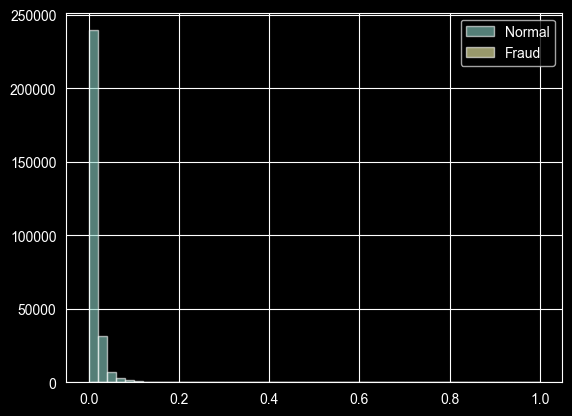

In [13]:
plt.hist(probs[y==0], bins=50, alpha=0.6, label="Normal")
plt.hist(probs[y==1], bins=50, alpha=0.6, label="Fraud")
plt.legend()
plt.show()


In [14]:
df_eval = df.copy()
df_eval["fraud_prob"] = probs
df_eval.sort_values("fraud_prob", ascending=False).head(10)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,fraud_prob
42700,41204.0,-8.440284,6.147653,-11.683706,6.702780,-8.155839,-3.716264,-12.407313,5.626571,-6.232161,...,-0.282597,0.008068,0.403858,-0.018788,0.522722,0.792691,0.067790,30.26,1,0.999604
42609,41170.0,-6.498086,4.750515,-8.966558,7.098854,-6.958376,-2.822126,-10.333406,4.031907,-6.648778,...,0.111510,0.216414,0.584661,0.760360,0.081972,1.415068,0.035124,83.38,1,0.999599
42635,41181.0,-7.334341,4.960892,-8.451410,8.174825,-7.237464,-2.382711,-11.508842,4.635798,-6.557760,...,0.033922,-0.014095,0.625250,-0.053390,0.164709,1.411047,0.315645,11.38,1,0.999599
150679,93879.0,-12.833631,7.508790,-20.491952,7.465780,-11.575304,-5.140999,-14.020564,8.332120,-4.337713,...,0.615344,-0.766495,0.431261,-0.104975,-0.010091,-2.400811,-0.720557,104.03,1,0.999599
150680,93879.0,-12.833631,7.508790,-20.491952,7.465780,-11.575304,-5.140999,-14.020564,8.332120,-4.337713,...,0.615344,-0.766495,0.431261,-0.104975,-0.010091,-2.400811,-0.720557,104.03,1,0.999599
43160,41397.0,-14.970346,8.401421,-16.867238,8.252334,-13.565130,-2.782438,-14.263735,9.643419,-7.701499,...,-0.101355,-0.439666,0.519514,0.789328,0.064357,-1.621386,-1.104819,273.01,1,0.999599
150678,93879.0,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,...,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,30.31,1,0.999599
150677,93879.0,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,...,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,30.31,1,0.999599
42945,41308.0,-13.680760,6.990389,-13.770001,8.694897,-11.426968,-2.919845,-14.594562,8.622905,-8.090697,...,0.497599,-0.509290,0.732503,0.280528,0.280037,-1.406687,-0.663643,0.76,1,0.999599
43681,41607.0,-18.247513,8.713250,-17.880127,9.249459,-14.541213,-1.911564,-18.014660,5.522162,-9.283925,...,0.615319,-0.486499,0.739268,-0.236845,-0.046082,-3.011473,-1.022147,53.95,1,0.999598
